In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-29 10:04:52.881561: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 10:04:53.980158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-29 10:04:53.980315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-29 10:04:53.980325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging'
background = 50
photons_per_pixel = 400
patch_size = 78
gaussian_noise_sigma = 15
sample = '2_plane_lung_uniform_patches_gaussian_noise_sigma_15'

single_lens_data = np.load(os.path.join(data_path, '2_plane_lung_single_lens.npy'))
double_lens_data = np.load(os.path.join(data_path, '2_plane_lung_double_lens.npy'))
many_lens_data = np.load(os.path.join(data_path, '2_plane_lung_many_lens.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())

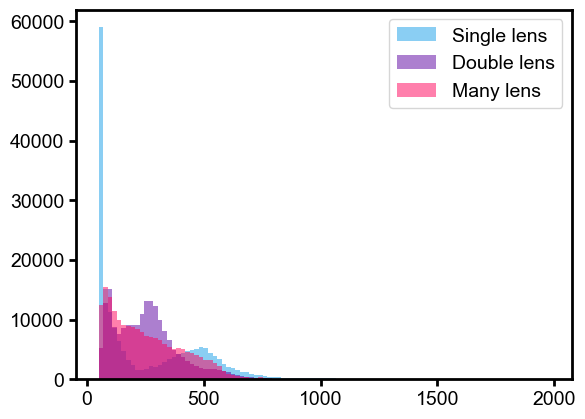

In [9]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

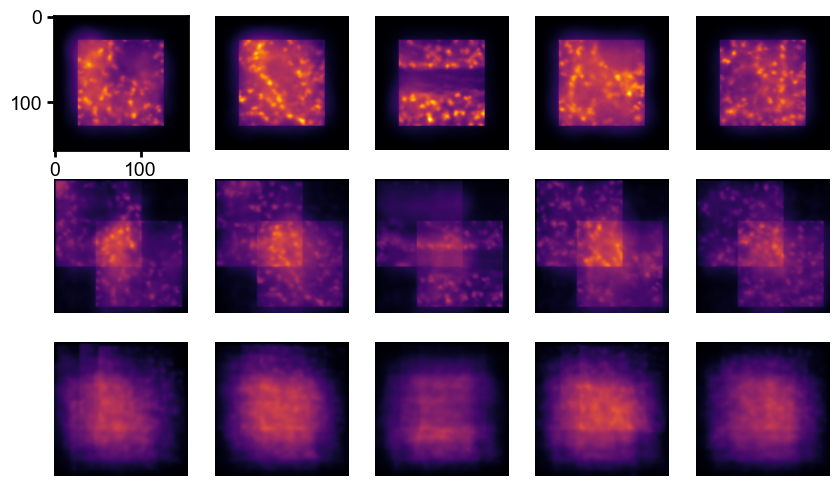

In [3]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

In [16]:
single_lens_data.shape

(3000, 156, 156)

# Generate and train

100%|██████████| 10/10 [00:00<00:00, 118.73it/s]


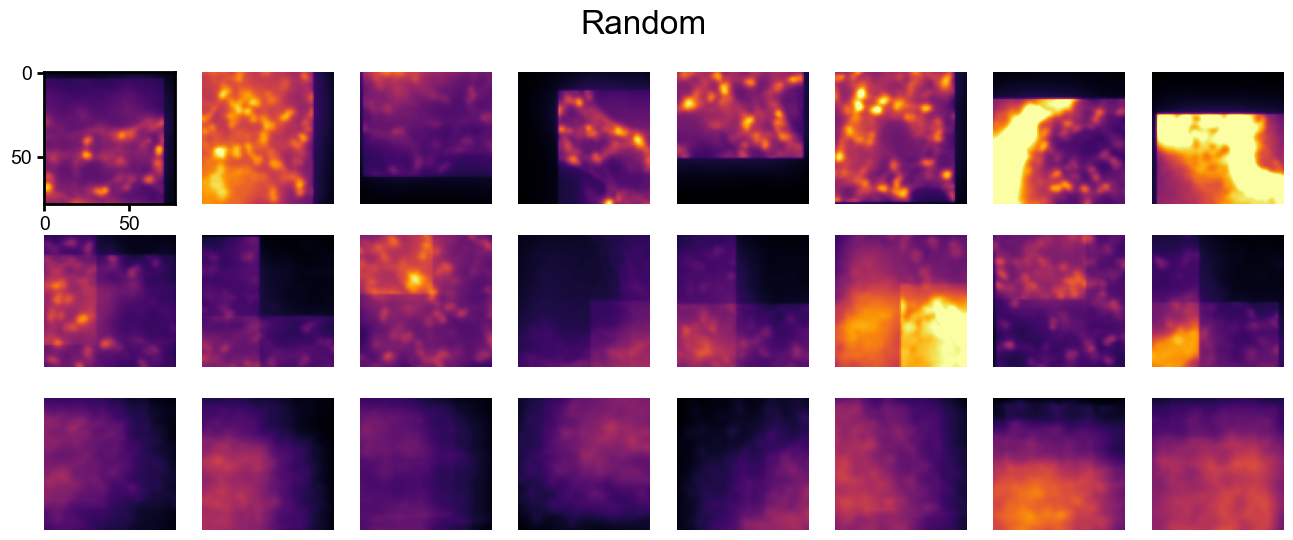

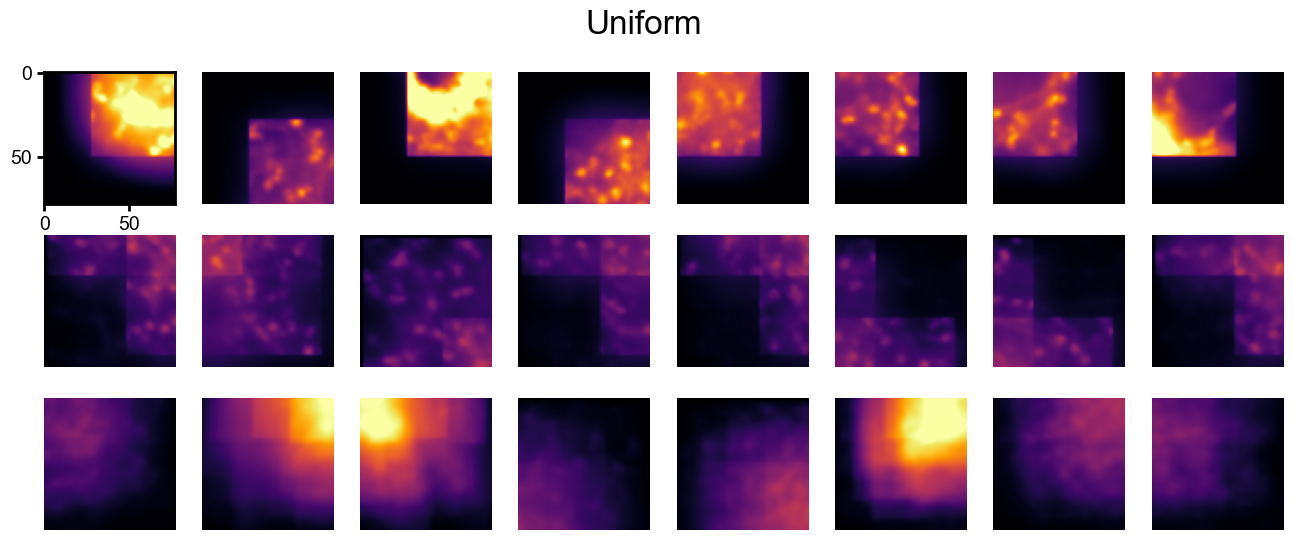

In [3]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]


vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


for uniform in [False, True]:

    if uniform:
        single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
    else:
        single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        

    fig, axs = plt.subplots(3, 8, figsize=(16, 6))

    for i in range(8):
        axs[0, i].imshow(single_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[1, i].imshow(double_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[2, i].imshow(many_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        if i != 0:
            axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[2, i].axis('off')
    fig.suptitle('Uniform' if uniform else 'Random')

In [4]:

for i in range(10):

    # single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches, gaussian_sigma=gaussian_noise_sigma)
    double_lens_noisy_patches = add_noise(double_lens_patches, gaussian_sigma=gaussian_noise_sigma)
    many_lens_noisy_patches = add_noise(many_lens_patches, gaussian_sigma=gaussian_noise_sigma)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, gaussian_noise_sigma=gaussian_noise_sigma,
                                                      entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, 
                                                      gaussian_noise_sigma=gaussian_noise_sigma,
                                                      entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, gaussian_noise_sigma=gaussian_noise_sigma,
                                                    entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, 
                                                            gaussian_noise_sigma=gaussian_noise_sigma,
                                                          verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,
                                                          gaussian_noise_sigma=gaussian_noise_sigma,
                                                            verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches,
                                                        gaussian_noise_sigma=gaussian_noise_sigma,
                                                         verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')

    save_data(single_lens_mi_gaussian, 'gaussian', 'single_lens')
    save_data(double_lens_mi_gaussian, 'gaussian', 'double_lens')
    save_data(many_lens_mi_gaussian, 'gaussian', 'many_lens')

KeyboardInterrupt: 

: 

: 